In [22]:
# import custom and regular modules
import sys
%load_ext autoreload
%autoreload 2
if "../src" not in sys.path: sys.path.append("../src")

from df_info_str import df_info_str
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
## read in email-customer-attributes table

# read
custatts = pd.read_csv("../data_transformed/email_customers/"
    "custatts_dateskeylvl.csv")
print("\ndf_info_str(custatts):\n\n" + df_info_str(custatts))


df_info_str(custatts):

info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2941871 entries, 0 to 2941870
Data columns (total 9 columns):
subkey             object
date               object
sport              object
visits_vid_live    int64
visits_vid_fer     int64
visits_vid_hl      int64
visits_vid_eng     int64
visits_ed          int64
visits             int64
dtypes: int64(6), object(3)
memory usage: 202.0+ MB
head():
                                 subkey        date    sport  visits_vid_live  \
0  000018a2-84d4-40ca-a942-f7224f246357  2019-05-20  unknown                0   
1  000018a2-84d4-40ca-a942-f7224f246357  2019-07-03  unknown                0   
2  000031d2-05bc-4b8f-b5a9-ae4327dba079  2019-06-20  unknown                0   
3  000031d2-05bc-4b8f-b5a9-ae4327dba079  2019-07-16  unknown                0   
4  000031d2-05bc-4b8f-b5a9-ae4327dba079  2019-08-02  unknown                0   

   visits_vid_fer  visits_vid_hl  visits_vid_eng  visits_ed  visits  
0         

In [24]:
## Focus on returning customers in specific months

# custatts in certain months
monthstrs = ["2019-07", "2019-08"]
custatts_period = custatts[custatts["date"].str.contains("|".join(monthstrs))]
print("\ncustatts_period n_subkeys = " 
    + str(custatts_period["subkey"].drop_duplicates().count()))

# keep only subkeys that have appeared previously
# "returning subkeys": "subkeys_ret"
#
# get subkeys appearing before period and in first 30 days
subkeys_period = custatts_period["subkey"].drop_duplicates().values
maxentrydate = str(pd.to_datetime(custatts_period["date"].min()) 
    + pd.to_timedelta("30 days"))[:10]
subkeys_prior = custatts[custatts["date"] < maxentrydate]\
    ["subkey"].drop_duplicates().values
#
# intersection
subkeys_ret = set(subkeys_period).intersection(set(subkeys_prior))
#
# restrict custatts_period to returning customers
custatts_ret = custatts_period[custatts_period["subkey"].isin(subkeys_ret)]
print("\ncustatts_ret n_subkeys = " 
    + str(custatts_ret["subkey"].drop_duplicates().count()))

print("\ndf_info_str(custatts_ret):\n\n" + df_info_str(custatts_ret))


custatts_period n_subkeys = 373736

custatts_ret n_subkeys = 304570

df_info_str(custatts_ret):

info():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914504 entries, 1 to 2941868
Data columns (total 9 columns):
subkey             object
date               object
sport              object
visits_vid_live    int64
visits_vid_fer     int64
visits_vid_hl      int64
visits_vid_eng     int64
visits_ed          int64
visits             int64
dtypes: int64(6), object(3)
memory usage: 146.1+ MB
head():
                                 subkey        date    sport  visits_vid_live  \
1  000018a2-84d4-40ca-a942-f7224f246357  2019-07-03  unknown                0   
3  000031d2-05bc-4b8f-b5a9-ae4327dba079  2019-07-16  unknown                0   
4  000031d2-05bc-4b8f-b5a9-ae4327dba079  2019-08-02  unknown                0   
6  00006416-4c39-4147-8d25-0b10a78b3783  2019-08-13  unknown                0   
7  00006416-4c39-4147-8d25-0b10a78b3783  2019-08-22  unknown                0   

   visi

In [33]:
## Aggregate out sport (select sport in future) and date

# agg
visitcols = list(custatts_ret.columns[
    custatts_ret.columns.str.contains("visit")])
catts_skeylvl = custatts_ret.groupby(["subkey"])[visitcols].sum()\
    .reset_index()

print("\ndf_info_str(catts_skeydatelvl):\n\n" + df_info_str(catts_skeylvl))


df_info_str(catts_skeydatelvl):

info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304570 entries, 0 to 304569
Data columns (total 7 columns):
subkey             304570 non-null object
visits_vid_live    304570 non-null int64
visits_vid_fer     304570 non-null int64
visits_vid_hl      304570 non-null int64
visits_vid_eng     304570 non-null int64
visits_ed          304570 non-null int64
visits             304570 non-null int64
dtypes: int64(6), object(1)
memory usage: 16.3+ MB
head():
                                 subkey  visits_vid_live  visits_vid_fer  \
0  000018a2-84d4-40ca-a942-f7224f246357                0               0   
1  000031d2-05bc-4b8f-b5a9-ae4327dba079                0               0   
2  00006416-4c39-4147-8d25-0b10a78b3783                0               0   
3  0000bb76-deed-4834-a9b1-70d9801e1d34                0               0   
4  0000e736-a65e-42d6-b30f-06ed52f2af59                0               0   

   visits_vid_hl  visits_vid_eng  visits_ed 

In [34]:
# Bring in full-period email opens for the subkeys

# read in email opens data
opensdf = pd.read_csv("../data_transformed/email_customers/"
    "emailcustomer_emailopens.csv")
print("\ndf_info_str(opensdf):\n\n" + df_info_str(opensdf))

# keep only dates in period
opensdf = opensdf[opensdf["date"].str.contains("|".join(monthstrs))]

# sum to subkey level
# (turn pianoid col to str during groupby to avoid dropping nans)
opensdf["pianoid"] = opensdf["pianoid"].astype(str)
opens_skeylvl = opensdf.groupby(["subkey", "pianoid"])["n_events"].sum()\
    .reset_index()
opens_skeylvl["pianoid"] = opens_skeylvl["pianoid"].replace("nan", np.nan)

# set junk pianoids to null
opens_skeylvl.loc[:, "pianoid"] = opens_skeylvl["pianoid"]\
    .replace(r"\n", np.nan)

# rename col n_events to emailopens
opens_skeylvl = opens_skeylvl.rename(columns={"n_events": "emailopens"})

# join with catts_skeylvl
#
catts_skeylvl = catts_skeylvl.merge(opens_skeylvl, how="left")
#
# set nulls to 0
catts_skeylvl.loc[:, "emailopens"] = catts_skeylvl["emailopens"]\
    .replace(np.nan, 0)

print("\ndf_info_str(catts_skeylvl):\n\n" + df_info_str(catts_skeylvl))


df_info_str(opensdf):

info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13092113 entries, 0 to 13092112
Data columns (total 4 columns):
date        object
subkey      object
pianoid     object
n_events    int64
dtypes: int64(1), object(3)
memory usage: 399.5+ MB
head():
         date                                subkey          pianoid  n_events
0  2019-05-18  00011564-c66a-49e0-8672-38eb0a582a81              NaN         1
1  2019-05-18  0001eaed-f26c-4241-a025-94d65869f02e  pniwwokz8ouq9k0         1
2  2019-05-18  0002aac2-85bf-40ea-8ca4-f39b17fe32dc              NaN         4
3  2019-05-18  00041111-6fac-4105-92d3-22493cc1e677              NaN         1
4  2019-05-18  00046309-f4d6-4914-a7f9-ea19af30fd08              NaN        12

df_info_str(catts_skeylvl):

info():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 304570 entries, 0 to 304569
Data columns (total 9 columns):
subkey             304570 non-null object
visits_vid_live    304570 non-null int64
visits_vid_fer


catts_opensbound["emailopens"].describe():

count    297724.000000
mean         44.759643
std          58.046087
min           0.000000
25%           7.000000
50%          21.000000
75%          58.000000
max         306.000000
Name: emailopens, dtype: float64

len(subkeys_outlier_opens) = 6846


<IPython.core.display.Javascript object>


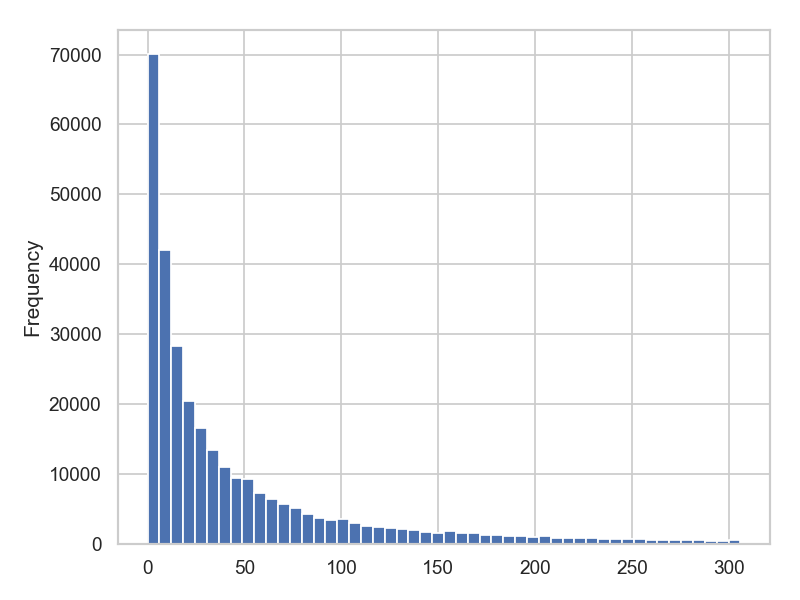

In [40]:
# look at distribution of emailopens

# discarding custs outside n sigma
n_sigma = 3
opens_mean = catts_skeylvl["emailopens"].mean()
opens_std = catts_skeylvl["emailopens"].std()
catts_opensbound = catts_skeylvl[catts_skeylvl["emailopens"] 
    < opens_mean + n_sigma*opens_std]
print('\ncatts_opensbound["emailopens"].describe():\n' 
    + str(catts_opensbound["emailopens"].describe()))

# saving list of outlier subkeys
subkeys_outlier_opens = set(catts_skeylvl["subkey"])\
    - set(catts_opensbound["subkey"])
print("\nlen(subkeys_outlier_opens) = " + str(len(subkeys_outlier_opens)))

# plot dist
plt.figure()
catts_opensbound["emailopens"].plot(kind="hist", bins=50)
plt.tight_layout()

In [43]:
# look at distribution of visits

# discarding custs outside n sigma
n_sigma = 3
visits_mean = catts_skeylvl["visits"].mean()
visits_std = catts_skeylvl["visits"].std()
print("\n(visits_mean, visits_std) = ", str((visits_mean, visits_std)))
catts_visitsbound = catts_skeylvl[catts_skeylvl["visits"] 
    < visits_mean + n_sigma*visits_std]
print('\ncatts_visitsbound["visits"].describe():\n' 
    + str(catts_visitsbound["visits"].describe()))

# saving list of outlier subkeys
subkeys_outlier_visits = set(catts_skeylvl["subkey"])\
    - set(catts_visitsbound["subkey"])
print("\nlen(subkeys_outlier_visits) = " + str(len(subkeys_outlier_visits)))

# plot dist
plt.figure()
catts_visitsbound["visits"].plot(kind="hist", bins=50)
plt.tight_layout()


(visits_mean, visits_std) =  (9.471152772761599, 16.752096786990787)

catts_visitsbound["visits"].describe():
count    299580.000000
mean          8.116560
std          10.048585
min           1.000000
25%           2.000000
50%           4.000000
75%          10.000000
max          59.000000
Name: visits, dtype: float64

len(subkeys_outlier_visits) = 4990


<IPython.core.display.Javascript object>

In [45]:
# removing outliers from emailopens and visits

print("\nlen(catts_skeylvl) = " + str(len(catts_skeylvl)))

subkeys_outlier_all = subkeys_outlier_visits.union(subkeys_outlier_opens)
print("\nlen(subkeys_outlier_all) = " + str(len(subkeys_outlier_all)))
catts_inlier = catts_skeylvl[~(catts_skeylvl["subkey"]
    .isin(subkeys_outlier_all))]
print("\nlen(catts_inlier) = " + str(len(catts_inlier)))


len(catts_skeylvl) = 304570

len(subkeys_outlier_all) = 11207

len(catts_inlier) = 293363


In [54]:
## Bucket customers by emailopens

bin_edges = [-1, 10, 50, 100, 500]
catts_inlier["emailopens_bucket"] = pd.cut(
    catts_inlier["emailopens"], bin_edges).astype(str)
catts_inlier["emailopens_bucket"].value_counts()

print("\ndf_info_str(catts_inlier):\n\n" + df_info_str(catts_inlier))

# save
date_start, date_end = custatts_ret["date"].min().replace("-", ""),\
    custatts_ret["date"].max().replace("-", "")
outpath = "../data_transformed/email_customers/"\
    "custatts_skeylvl_" + date_start + "to" + date_end + ".csv"
# if not os.path.exists(os.path.dirname(outpath)):
#     os.makedirs(os.path.dirname(outpath))
# catts_inlier.to_csv(outpath, index=False)

print('\ncatts_inlier["emailopens_bucket"].value_counts():\n' 
      + str(catts_inlier["emailopens_bucket"].value_counts().sort_index()))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """



df_info_str(catts_inlier):

info():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 293363 entries, 0 to 304569
Data columns (total 10 columns):
subkey               293363 non-null object
visits_vid_live      293363 non-null int64
visits_vid_fer       293363 non-null int64
visits_vid_hl        293363 non-null int64
visits_vid_eng       293363 non-null int64
visits_ed            293363 non-null int64
visits               293363 non-null int64
pianoid              20159 non-null object
emailopens           293363 non-null float64
emailopens_bucket    293363 non-null object
dtypes: float64(1), int64(6), object(3)
memory usage: 24.6+ MB
head():
                                 subkey  visits_vid_live  visits_vid_fer  \
0  000018a2-84d4-40ca-a942-f7224f246357                0               0   
1  000031d2-05bc-4b8f-b5a9-ae4327dba079                0               0   
2  00006416-4c39-4147-8d25-0b10a78b3783                0               0   
3  0000bb76-deed-4834-a9b1-70d9801e1d34    

In [53]:
catts_inlier["emailopens"].max()

306.0